In [2]:
import numpy as np

import scipy as sc
import scipy.io as scio # for loading .mat file
from scipy import linalg
from scipy.spatial import KDTree

from sklearn.decomposition import PCA as PCAdimReduc
from sklearn.feature_extraction import DictVectorizer

import networkx as nx

import pygmtools as pygm

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import cv2

import shapely

import svgpathtools
import drawsvg as draw

from bplustree import BPlusTree
from bplustree.serializer import Serializer
from bplustree.node import Node

import pickle

from xml.dom import minidom

import functools
from itertools import product, combinations
from typing import Optional, Tuple, List
from collections import Counter, defaultdict

import struct

import os, errno
import sys

import random

pygm.BACKEND = 'numpy' # set numpy as backend for pygmtools

# TOPOLOGY GRAPH / GEOMETRY EXTRACTION

In [3]:
from src.svg import *
from src.extraction import *
from src.database import *
from src.matching import *

{'attrib': {'fill': 'none', 'stroke': 'black', 'stroke-linecap': 'round', 'stroke-linejoin': 'round', 'stroke-width': '1.3537', 'transform': 'translate(87.52,138.4919) scale(2.2162) translate(-180,-104)'}, 'paths': [Path(CubicBezier(start=(325+193j), control1=(325+193j), control2=(319.8642+192.034j), end=(316+193j)),
     CubicBezier(start=(316+193j), control1=(310.7404+194.3149j), control2=(309.5617+194.6053j), end=(305+198j)),
     CubicBezier(start=(305+198j), control1=(288.8575+210.013j), control2=(287.8161+211.4186j), end=(273+225j)),
     CubicBezier(start=(273+225j), control1=(270.5198+227.2735j), control2=(269.9805+228.0586j), end=(269+231j)),
     CubicBezier(start=(269+231j), control1=(267.7521+234.7436j), control2=(266.8215+237.4286j), end=(268+240j)),
     CubicBezier(start=(268+240j), control1=(270.8285+246.1713j), control2=(273.7215+249.0355j), end=(280+255j)),
     CubicBezier(start=(280+255j), control1=(282.8223+257.6812j), control2=(284.1572+258.4178j), end=(288+259j))

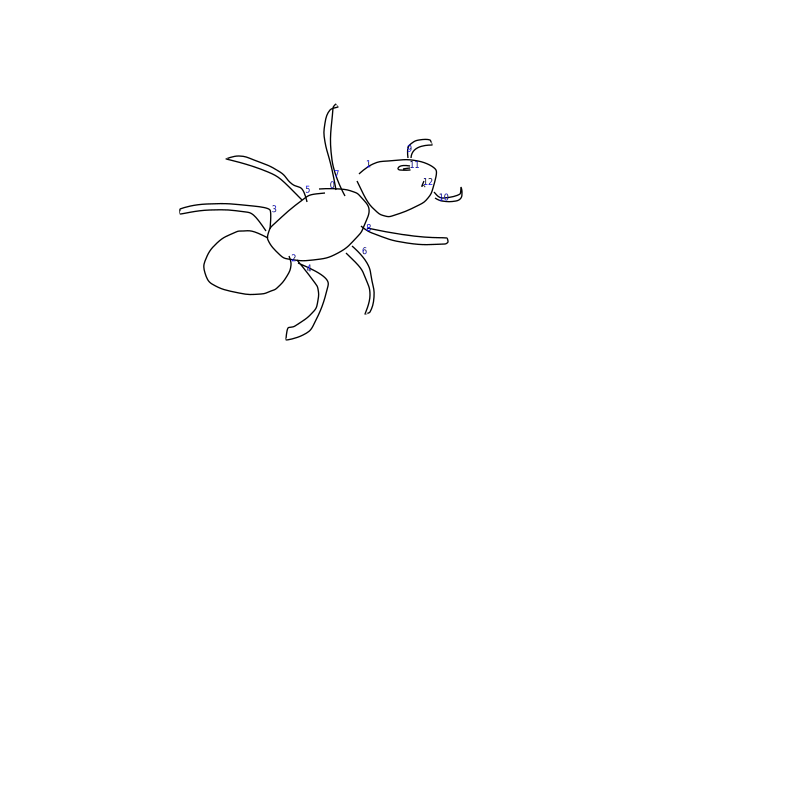

In [6]:
svg = load('assets/svg/ant/269.svg')
print(svg)
display(svg)

In [8]:
line_strings = get_line_strings(map(to_control_points, svg['paths']), step=10)

LINESTRING (320 190, 320 190, 310 190, 310 190, 310 190, 310 190, 300 190, 300 190, 300 190, 280 210, 280 210, 270 220, 270 220, 270 220, 260 220, 260 230, 260 230, 260 230, 260 230, 260 240, 260 240, 270 240, 270 240, 280 250, 280 250, 280 250, 280 250, 280 250, 280 250, 290 260, 300 260, 310 260, 310 260, 320 250, 320 250, 330 250, 330 250, 340 240, 340 240, 350 230, 350 230, 360 230, 360 230, 360 220, 360 220, 360 210, 360 210, 360 200, 360 200, 360 200, 360 200, 360 190, 360 190, 350 190, 350 190, 350 190, 350 190, 340 180, 340 180, 340 180, 340 180, 320 180, 310 180, 310 180)
<class 'shapely.geometry.linestring.LineString'>
307.27922061357856
14.142135623730951


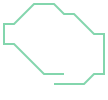

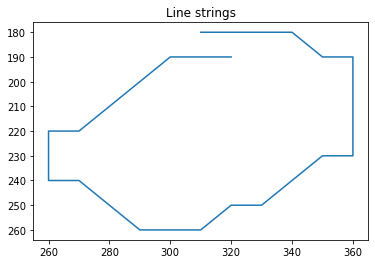

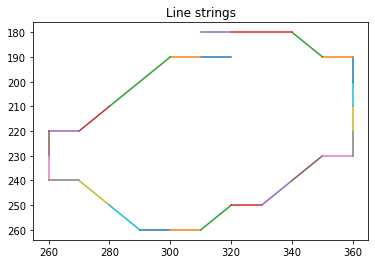

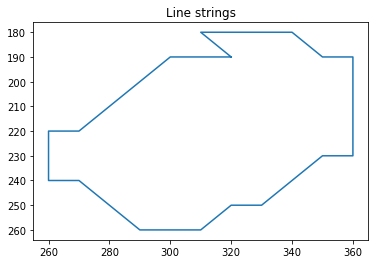

In [10]:
index = 0
ls = line_strings[index]

print(ls)
print(type(ls))
print(ls.length)

s, t = get_endpoints(ls)
print(s.distance(t))

plot_line_strings([ls])

segments = get_segments(ls)

# Plot segmented line string
plot_line_strings(segments)

# Plot closed line string
plot_line_strings([detect_approximate_polygon(ls)])

ls

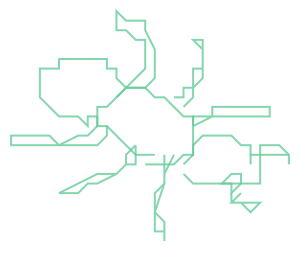

In [11]:
DEBUG = shapely.MultiLineString(line_strings)
DEBUG

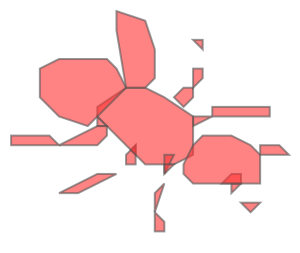

In [12]:
polygons = get_polygons(line_strings)

shapely.MultiPolygon(polygons)

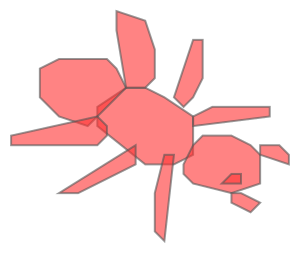

In [13]:
hulls = get_hulls(line_strings)

s = shapely.MultiPolygon(hulls)
s

### EXTRACTION

In [ ]:
svg = load('assets/svg/ant/279.svg')
display(svg)

In [ ]:
G = extract_graph(svg, 'ant')
plot_graph(G)

# DATABASE

## Offline graph extraction

In [ ]:
# # Extract graphs for each sketch in the dataset, offline processing step

# paths = get_files()
# print(len(paths))

# images = load_images(paths)

# graphs = extract_graphs(images)
# print(len(graphs))

# # Dump the graphs to avoid this offline step later
# dump_graphs(graphs)

In [ ]:
# Load graphs from disk
graphs = load_graphs()

len(graphs)

## DIMENSIONALITY REDUCTION

In [ ]:
# Check the statistics for number of nodes

n = [len(g.nodes) for g in graphs]

fig = plt.figure()

# hist = np.histogram(n, bins=range(170))

plt.hist(n, bins=170) #, density=True)

plt.xticks(np.arange(0, 170, step=10))

print('max: ', max(n))
print('min: ', min(n))
print('99% percentile: ', np.percentile(n, 99))

In [ ]:
# Check the statistics for number of edges

e = [len(g.edges) for g in graphs]

# hist = np.histogram(e, bins=range(170))

fig = plt.figure()

plt.hist(e, bins=400) #, density=True)

plt.xticks(np.arange(0, 400, step=30))

print('max: ', max(e))
print('min: ', min(e))
print('99% percentile: ', np.percentile(e, 99))

In [ ]:
# Check descriptor collisions for a given descriptor length

maximum = max(n)

print('100th percentile (maximum): ', maximum )

descriptors_max = [descriptor(g, N=maximum).tobytes() for g in graphs]

c_max = Counter(descriptors_max)

print('Unique descriptors: ', list(c_max.values()).count(1))

[(np.frombuffer(d, dtype=float), c) for d, c in c_max.most_common()]

In [ ]:
# Check descriptor collisions for a given descriptor length

percent = 58

percentile = int(np.percentile(n,percent))

print(f'{percent}th percentile: ', percentile)

descriptors = [descriptor(g, N=percentile).tobytes() for g in graphs]

c_percentile = Counter(descriptors)

print('Unique descriptors: ', list(c_percentile.values()).count(1))

[(np.frombuffer(d, dtype=float), c) for d, c in c_percentile.most_common()]

In [ ]:
unique_graphs = {d : g for g, d in zip(graphs, descriptors) if (count := c_percentile[d]) == 1}

print(len(unique_graphs))

c = Counter(map(lambda g: g.graph['label'], unique_graphs.values()))
print(len(c))

# plt.figure(figsize=(100,100))

# plt.bar(c.keys(), c.values(), orientation='horizontal')

# plt.show()

# c

In [ ]:
# Check the statistics of each label (plots histograms of deperecated index).

def plot_hist(graphs):
    results = defaultdict(list)

    for g in graphs: 
        results[g.graph['label']].append(index(g))

    fig = plt.figure()
    fig, axs = plt.subplots(len(results), 1, figsize=(14,800))
    
    for i, k in enumerate(results):
        plt.subplot(len(results), 1, i+1)
        
        axs[i].title.set_text(k)
        axs[i].hist(results[k], bins=100)

    plt.axis('off')

    plt.show()

In [ ]:
# plot_hist(graphs)

### Dump unique graphs with no descriptor collisions

In [ ]:
dump_graphs(unique_graphs, prefix="unique_")

## Database construction

### In-memory KD-tree for KNN descriptor queries

In [ ]:
DESCRIPTOR_DIMENSION = 11

In [ ]:
unique_graphs = load_graphs(prefix="unique_")
assert isinstance(unique_graphs, dict) 

In [ ]:
descriptors = np.array([np.frombuffer(d, dtype=float) for d in unique_graphs.keys()])

print(descriptors.shape)
descriptors

In [ ]:
# Build kd-tree
kd_tree = KDTree(descriptors)

In [ ]:
# Load graph from query image
svg = load('assets/svg/ant/270.svg')
display(svg)

In [ ]:
# Test query
query = extract_graph(svg, 'ant')
plot_graph(query)

#serialize_graph(query)

In [ ]:
# # Get query descriptor
# d = descriptor(query, N=DESCRIPTOR_DIMENSION)
# print(d)

# # Query KD-tree
# dd, ii = kd_tree.query(d, k=100)

# # Plot KNN
# for i in ii:
#     g = unique_graphs[descriptors[i].tobytes()]
#     plot_graph(g)
# # display(load(g.graph['filename']))

### Disk B+-tree mapping descriptors to graph data

In [ ]:
# Construct database for online use
db = construct_database(unique_graphs.values())

In [ ]:
# Test query
svg = load('assets/svg/ant/279.svg')

query = extract_graph(svg, 'ant')
plot_graph(query)

print(descriptor(query))

candidates = query_database(db, query)
print(candidates, "\n")

In [ ]:
db.close()

In [ ]:
# Reopen database

db = open_database()
candidates = query_database(db, query)
db.close()

candidates

# GRAPH MATCHING

In [ ]:
G = nx.tutte_graph()
G.graph['positions'] = nx.spring_layout(G)

In [ ]:
nx.draw(G, pos=G.graph['positions'])

In [ ]:
ax1 = plt.subplot(1, 2, 1)
plot_graph(G)

ax2 = plt.subplot(1, 2, 2)
plot_graph(G)

In [ ]:
X = match(G, G)
print(X.shape)
X

In [ ]:
plot_mapping(X, G, G)